In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Bayesian General Linear Models

Bayes Theorem and Bayesian inference is used to determine posterior probability distributions. 

Here, Bayesian Inference is applied to a General Linear Model (GLM) for regression. 

### The Model
The objective is to *develop a model to predict student grades* given several input factors for student demographics. The publicly avaliable [UCI dataset](https://archive.ics.uci.edu/ml/datasets/student+performance#) contains grades and factors for 649 students taking a Portugese language course. 

In [2]:
os.listdir('./data')
raw = pd.read_csv('./data/student-por.csv',sep=';')

**Dependent variable or "Target"**
- "G3" is the students final grade for portugese (numeric: from 0 to 20, output target)

***Independent variables or "Features"***

A subset of numeric and categorical features is used to build the initial model:
- "age" student age from 15 to 22
- "internet"  student has internet access at home (binary: yes or no)
- "failures" is the number of past class failures (cat: n if 1<=n<3, else 4) 
- "higher" wants to take higher education (binary: yes or no) 
- "Medu" mother's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  ""Fedu father's education (cat: 0 - none, 1 - primary education (4th grade), 2 5th to 9th grade, 3 secondary education or 4 higher education)
-  "studytime" weekly study time (cat: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- "absences" number of school absences (numeric: from 0 to 93) 

In [3]:
# prep Xy data
df = raw.loc[~raw['G3'].isin([0])].copy()
print(df.shape)

# prep features
categoricals = ['internet','failures','higher','Medu','Fedu','studytime']
reals = ['age','absences',]
features = categoricals+reals
target = ['G3']
df = df[features+target].copy()
df[:1]

(634, 33)


,internet,failures,higher,Medu,Fedu,studytime,age,absences,G3
0,no,0,yes,4,4,2,18,4,11


## PyMC3 OOS Predictions

- https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e
- https://github.com/WillKoehrsen/Data-Analysis/blob/master/bayesian_lr/Bayesian%20Linear%20Regression%20Project.ipynb
- https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets
- https://docs.pymc.io/notebooks/posterior_predictive.html?highlight=posterior%20predictive%20checks#Prediction
- https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3
- https://twiecki.io/blog/2013/08/12/bayesian-glms-1/
- https://www.sciencedirect.com/topics/mathematics/highest-density-interval

$y = a + b*x$

In [4]:
import pymc3 as pm
import arviz as avz
from theano import shared

***method 1: [Theano shared variable to update xtrain vairbale](https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets)***

In [5]:
Xy = df[['G3','Fedu','studytime','age','absences']].copy()

train,test = Xy[:500],Xy[500:]
trainx,testx = train.drop(labels=['G3'],axis=1),test.drop(labels=['G3'],axis=1)
trainy,testy = train['G3'].copy(),test['G3'].copy()

# Shared variable for modelling
# must be np.array()
modelx = shared(np.array(trainx))

In [6]:
bglm = pm.Model()
with bglm:
    
    # Priors 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    betas = pm.Normal('beta', mu=0, sd=10, shape=4)
    sigma = pm.HalfNormal('sigma', sd=1)
    
    # Expected value of outcome (aka linear formula)
    mu = alpha + pm.math.dot(betas, modelx.T)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=trainy)
    
    # sample   
    trace = pm.sample(1000)

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8802289912004505, but should be close to 0.8. Try to increase the number of tuning steps.
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.


In [7]:
samples = 5

# Update model X and make Prediction
modelx.set_value(np.array(testx)) # update X data
ppc = pm.sample_posterior_predictive(trace, model=bglm, samples=samples,random_seed=6)
ppc['y'].shape

## which is equivalen to
# pc = pm.sample_posterior_predictive(trace,model=bglm, var_names=["y"],samples=25,random_seed=6)
# pc['y'].shape
# pc['y'] == ppc['y']

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


(5, 134)

In [8]:
# print samples for first r predictions
r = 3
for i in range(r):
    print(ppc['y'][:,i])

[13.43976955 16.54687305 12.8715088  13.70288469 14.55741184]
[13.31029819  9.90234038  8.49328656 13.94367484 15.23087523]
[12.83837751 10.73227268 16.3969308  13.84528616 16.98448653]


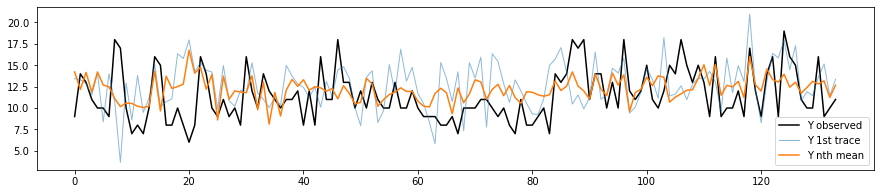

In [9]:
plt.figure(figsize=(15,3))
plt.plot(testy.reset_index(drop=True),'k-',label='Y observed')
plt.plot(ppc['y'][0,:],lw=1,alpha=0.5,label='Y 1st trace')
plt.plot(ppc['y'][:,:].mean(axis=0),label='Y nth mean')
plt.legend();

***method 2: [set data as variable and update](https://docs.pymc.io/notebooks/posterior_predictive.html?highlight=posterior%20predictive%20checks#Prediction)***

In [10]:
trainx.shape,trainy.shape

((500, 4), (500,))

In [11]:
bglm = pm.Model()
with bglm:
    
    # Priors 
    alpha = pm.Normal('alpha', mu=trainy.mean(), sd=50)
    betas = pm.Normal('beta', mu=0, sd=1000, shape=4)
    sigma = pm.HalfNormal('sigma', sd=1000)
    
    xdata = pm.Data("pred", trainx.T)
    
    # Expected value of outcome (aka linear formula)
    mu = alpha + pm.math.dot(betas, xdata)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=np.array(trainy).reshape(-1))
    
    # sample   
    trace = pm.sample(1000)

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [12]:
summary = avz.summary(trace)
summary[:5]

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,8.683,1.536,5.801,11.467,0.034,0.024,2090.0,2197.0,1.0
beta[0],0.451,0.100,0.255,0.630,0.002,0.001,2915.0,2514.0,1.0
beta[1],0.634,0.130,0.390,0.876,0.002,0.002,3150.0,2833.0,1.0
beta[2],0.105,0.091,-0.060,0.272,0.002,0.002,2121.0,2039.0,1.0
beta[3],-0.094,0.023,-0.136,-0.050,0.000,0.000,3093.0,2471.0,1.0


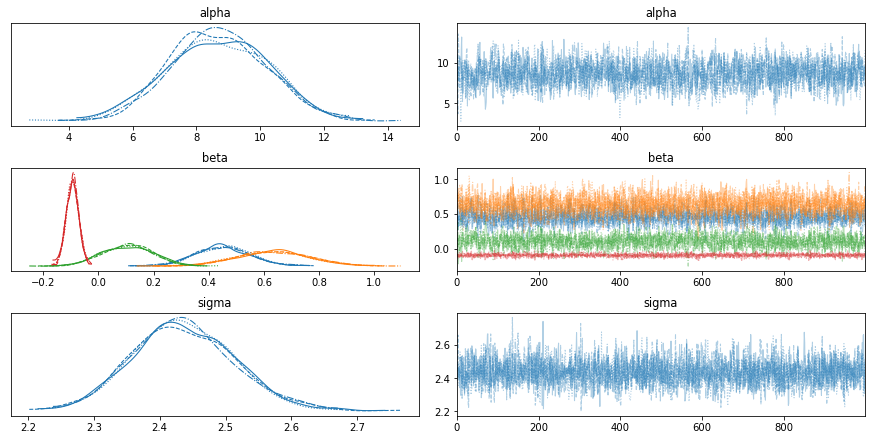

In [13]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    avz.plot_trace(trace)

In [14]:
with bglm:
    # update values of predictors:
    pm.set_data({"pred": testx.T})
    
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["y"], samples=600)
    model_preds = posterior_predictive["y"]

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/pymc3/sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [15]:
testy.shape,model_preds.shape

((134,), (600, 134))

/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/ben/miniconda3/envs/ml/lib/python3.8/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


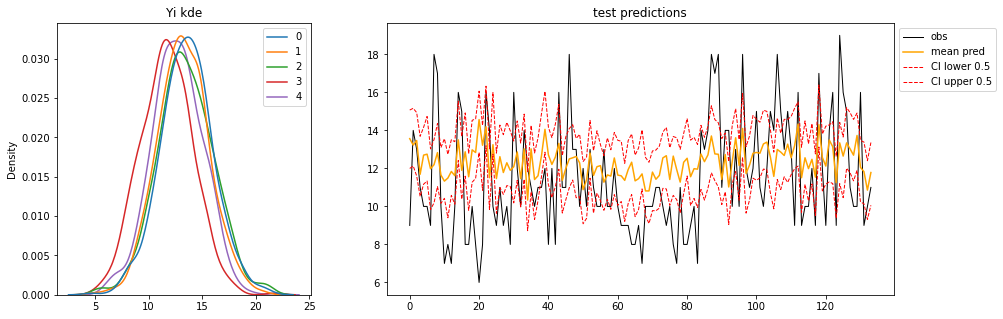

In [16]:
from matplotlib.gridspec import GridSpec

fig=plt.figure(figsize=(15,5))
gs=GridSpec(nrows=1,ncols=2,width_ratios=[1,2]) # 2 rows, 3 columns

ax0 = fig.add_subplot(gs[0])
ax0.set_title("Yi kde")
sns.kdeplot(data=pd.DataFrame(model_preds[:,:5]),ax=ax0)

ax1 = fig.add_subplot(gs[1])
ax1.set_title("test predictions")
ax1.plot(testy.reset_index(drop=True),'k-',lw=1,label='obs')
ax1.plot(model_preds.mean(0),c='orange',label='mean pred')

alpha = 1-0.5
ax1.plot(avz.hdi(model_preds,alpha)[:,0],ls='--',lw=1,c='red',label=f'CI lower {alpha}')
ax1.plot(avz.hdi(model_preds,alpha)[:,1],ls='--',lw=1,c='red',label=f'CI upper {alpha}')

ax1.legend(bbox_to_anchor=(1,1));

In [17]:
### try example from 
### https://docs.pymc.io/notebooks/posterior_predictive.html?highlight=posterior%20predictive%20checks#Prediction
# from scipy.special import expit as logistic

# N = 400
# true_intercept = 0.2
# true_slope = 1.0
# predictors = np.random.normal(size=N)
# true_p = logistic(true_intercept + true_slope * predictors)

# outcomes = np.random.binomial(1, true_p)

# with pm.Model() as model_2:
#     betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

#     # set predictors as shared variable to change them for PPCs:
#     pred = pm.Data("pred", predictors)
#     p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * pred))
#     outcome = pm.Bernoulli("outcome", p=p, observed=outcomes)
#     trace_2 = pm.sample(1000, tune=1000, random_seed=6)

# predictors_out_of_sample = np.random.normal(size=50)
# outcomes_out_of_sample = np.random.binomial(1, logistic(true_intercept + true_slope * predictors_out_of_sample))

# with model_2:
#     # update values of predictors:
#     pm.set_data({"pred": predictors_out_of_sample})
#     # use the updated values and predict outcomes and probabilities:
#     posterior_predictive = pm.sample_posterior_predictive(trace_2, var_names=["p"], random_seed=6)
#     model_preds = posterior_predictive["p"]
    
# model_preds.mean(0).shape

### method 3: try above with pm.from_formula()

- both of the methods above result in theano error: 
```ERROR! Session/line number was not unique in database. History logging moved to new session 11```


https://github.com/pymc-devs/pymc3/blob/master/pymc3/glm/linear.py#L101

In [30]:
import patsy

#         eval_env = patsy.EvalEnvironment.capture(eval_env, reference=1)
#         y, x = patsy.dmatrices(formula, data, eval_env=eval_env)

In [38]:
eval_env = patsy.EvalEnvironment.capture(reference=1)
eval_env

In [42]:
patsy.dmatrices(formula, df)[1].design_info.column_names

['Intercept', 'failures', 'Medu', 'Fedu', 'studytime', 'age', 'absences']

In [45]:
formula = "G3 ~ C(internet) + failures + C(higher) + Medu + Fedu + studytime + age + absences"
formula = "G3 ~ internet + failures + higher + Medu + Fedu + studytime + age + absences"
print(formula)

G3 ~ internet + failures + higher + Medu + Fedu + studytime + age + absences


In [46]:
df['internet'] = (df['internet']=='yes').astype(int)
df['higher'] = (df['higher']=='yes').astype(int)
df[:3]

train,test = df[:500],df[500:]
trainx,testx = train.drop(labels=['G3'],axis=1),test.drop(labels=['G3'],axis=1)
trainy,testy = train['G3'].copy(),test['G3'].copy()
df[:5]

,internet,failures,higher,Medu,Fedu,studytime,age,absences,G3
0,0,0,0,4,4,2,18,4,11
1,0,0,0,1,1,2,17,2,11
2,0,0,0,1,1,2,15,6,12
3,0,0,0,4,2,3,15,0,14
4,0,0,0,3,3,2,16,0,13


In [47]:
modelx = shared(np.array(train))

In [49]:
gl = pm.Model()
with gl:
    
    # Normally distributed priors
    family = pm.glm.families.Normal()
    
    modeldata = pm.Data("modeldata", df)
    
    # create the model 
    pm.GLM.from_formula(formula,data=df,family=family)
    
    # sample
    #output = pm.sample(999,return_inferencedata=True)

In [50]:
gl

- [pymcs predictions using shared theano variables 1](https://stackoverflow.com/questions/37312817/pymc3-bayesian-linear-regression-prediction-with-sklearn-datasets)
- [pymcs predictions using shared theano variables 2](https://stackoverflow.com/questions/33249122/generating-predictions-from-inferred-parameters-in-pymc3)
- [pymc3 posterior predctive docs](https://docs.pymc.io/notebooks/posterior_predictive.html)
- [pymce glm demo twiecki](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/)